In [1]:
import numpy as np

# Branch and bound algorithm for the traveling salesman problem

We illustrate here the branch and bound algorithm on the traveling salesman problem. Note that we do not rely on mathematical modeling. We simply exploit the structure of the problem to calculate bounds. 

## Traveling salesman problem

The following class implements the symmetric traveling salesman problem. It takes as input the distance between every pair of two cities. In particular, it allows to calculate tour lengths, lower bounds, and tour extension. These are the problem specific ingredients that are needed by the branch and bound algorithm.

### Lower bound calculation

The
calculation of the lower bound can be done using the following
reasoning. Each city in the tour involves two different arcs, one to reach the
city, and one to leave it. A lower bound on the length of
the two arcs incident to a city is obtained by considering the two
shortest arcs incident to that city. If we compute this lower bound
for all nodes and add them up, we have double counted each
arc (once for each of the two incident cities). Therefore, a lower
bound on the total path is obtained by dividing this quantity by two. 

Note that the method described in this document is designed to illustrate the branch and bound algorithm. These lower bounds are quite poor, and this is not an efficient way to solve the problem. 

In [2]:
class TSP:
    """
    Data management
    """
    def __init__(self, home, distances):
        self.distances = distances
        self.cities = set([c for k in self.distances.keys() for c in k])
        self.home = home
        if home not in self.cities:
            raise Exception(f'Home ({home}) does not belong to the list of cities: {self.cities}')
    def distance(self, c1, c2):    
        if (c1, c2) in self.distances:
            return self.distances[(c1, c2)]
        elif (c2, c1) in self.distances:
            return self.distances[(c2, c1)]
        else:
            raise Exception(f'Unknown pair of cities: {c1}-{c2}')
            
    def _contributionToLowerBound(self, city, fixed):
        if len(fixed) > 2:
            raise Exception(f'A maximum of two cities can be fixed: {fixed}')
        if city in fixed:
            raise Exception(f'City {city} cannot be in the list of fixed cities: {fixed}')
            
        # First calculate the distance from city to all other cities, excluding those that are fixed.
        allValues = [self.distance(city, i) for i in self.cities - set([city]) - set(fixed)]
        allValues.sort()
        if fixed:
            # The contributions to the lower bound combines fixed cities, and 
            values = [self.distance(city, i) for i in fixed] + allValues[:2-len(fixed)]
        else:
            values = allValues[:2]
        return sum(values)
    
    def tourLength(self, tour):
        if len(tour) != len(self.cities):
            raise Exception(f'This is not a valid tour. It covers {len(tour)} and not {len(self.cities)}')
        pairs = [(tour[i], tour[i + 1]) for i in range(len(tour) - 1)] + [(tour[-1], tour[0])]
        d = [self.distance(c1, c2) for (c1, c2) in pairs]
        return sum(d)
        
    def lowerBound(self, partialTour):
        # If all cities are involved, the tour is complete and the lower bound is the length of the tour.
        if len(partialTour) == len(self.cities):
            return self.tourLength(partialTour)
        
        fixedPairs = [(city, partialTour[i + 1]) for i, city in enumerate(partialTour[:-1])]
        fixedCities = {c: list() for c in self.cities}
        for c1, c2 in fixedPairs:
            fixedCities[c1].append(c2)
            fixedCities[c2].append(c1)
        bounds = [self._contributionToLowerBound(c, fixedCities[c]) for c in self.cities]
        return sum(bounds) / 2.0
    
    def extendTour(self, partialTour):
        if len(partialTour) == len(self.cities):
            raise Exception(f'Tour is already complete, Cannot be extended: {partialTour}')
        nonVisitedCities = self.cities - set(partialTour)
        newTours = [partialTour + [c] for c in nonVisitedCities]
        return newTours

## Subproblem

The branch and bound algorithm maintains a list of subproblems. The following class implements a subproblem. The key function is the "solve" function. It solves the problem to optimality if it is easy to do so, either because the problem it self is easy (typically, because only one city needs to be inserted), or because all the subproblems have been solved or discarded. 

In [3]:
class subproblem:
    def __init__(self, tsp, partialTour):
        self.tsp = tsp
        self.partialTour = partialTour
        self.branches = None
        self.lowerBound = self.tsp.lowerBound(self.partialTour)
        self.optimalValue = None
        self.optimalTour = None
        self.subproblems = None

        
    def __str__(self):
        if self.optimalValue is not None: 
            return f'{self.partialTour} ({self.optimalValue})'
        elif self.lowerBound is not None:
            return f'{self.partialTour} [{self.lowerBound}]'
        else:
            return f'{self.partialTour}'
            
    def isFeasible(self):
        # For TSP, all subproblems are feasible
        return True
    
    def calculateLowerBound(self):
        self.lowerBound = self.tsp.lowerBound(self.partialTour)
        return self.lowerBound
    
    def solve(self):
        # This function solves the problem is it is easy to do so, and returns False otherwise.
        # It also creates the branches, that is the subproblems.
        
        # If all the cities have been included, except one, the problem is trivial to solve.
        if len(self.partialTour) == len(self.tsp.cities) - 1:
            extendedTour = self.tsp.extendTour(self.partialTour)
            self.optimalTour = extendedTour[0]
            self.optimalValue = self.tsp.tourLength(self.optimalTour)
            return True
        
        # If no subproblem has been created, we create them
        if self.subproblems is None:
            extendedTours = self.tsp.extendTour(self.partialTour)
            self.subproblems = [subproblem(self.tsp, pt) for pt in extendedTours]
            return False
        
        bestTour = None
        bestValue = np.inf
        # We loop on the subproblems. If they have all been solved, the best solutiom
        # is the optimal solution of the current subproblem. 
        # If the optimal value is np.inf, it means that the problem has been discarded. 
        for p in self.subproblems: 
            if p.optimalValue is None:
                # The problem has not been treated. No way to solve the subproblem.
                return False
            else:
                if p.optimalValue < bestValue:
                    bestValue = p.optimalValue
                    bestTour = p.optimalTour
        self.optimalValue = bestValue
        self.optimalTour = bestTour
        return True

## Branch & bound

This is the branch and bound algorithm for the symmetric TSP problem.

In [4]:
def branchAndBound(tsp, firstTour=None):
    if firstTour is None:
        currentBestTour = [tsp.home] + [c for c in set(tsp.cities) - set([tsp.home])]
    else:
        currentBestTour = firstTour
    upperBound = tsp.tourLength(currentBestTour)
    fullProblem = subproblem(tsp,[tsp.home])
    setOfProblems = [fullProblem]
    iter = 0
    while setOfProblems:
        iter += 1
        currentProblem = setOfProblems[-1]
        if currentProblem.optimalValue == np.inf:
            setOfProblems.pop()
        else:
            print(f'======= Iteration {iter} =======')
            print(f'Current best tour: {currentBestTour} Length: {upperBound}')
            print(f'Treat problem {currentProblem}')
            lb = currentProblem.calculateLowerBound()
            if currentProblem.solve():
                if currentProblem.optimalValue < upperBound:
                    currentBestTour = currentProblem.optimalTour
                    upperBound = currentProblem.optimalValue
                # Remove the subproblem from the list
                print(f'--> Optimal solution of {currentProblem}: {currentProblem.optimalTour}')
                setOfProblems.pop()
            else:
                print(f'--> Branch')
                setOfProblems += currentProblem.subproblems
            # Discard problems with a lower bound worse than the current upperbound
            print('List of problems to treat:')
            for p in setOfProblems:
                if p.optimalValue != np.inf:
                    print(f'\t{p}')
            for p in setOfProblems:
                if p.optimalValue != np.inf and p.lowerBound >= upperBound:
                    print(f'Discard {p} because lb={p.lowerBound} >= {upperBound}')
                    p.optimalValue = np.inf
    return fullProblem

## Example 1 - 4 cities

In [5]:
distances = {('L', 'G'): 64,
            ('L', 'B'): 104,
            ('L', 'Z'): 228,
            ('G', 'B'): 158,
            ('G', 'Z'): 279,
            ('B', 'Z'): 125}
tsp = TSP('L', distances)

In [6]:
fullProblem = branchAndBound(tsp,['L', 'Z', 'B', 'G'])

======= Iteration 1 =======
Current best tour: ['L', 'Z', 'B', 'G'] Length: 575
Treat problem ['L'] [486.0]
--> Branch
List of problems to treat:
	['L'] [486.0]
	['L', 'Z'] [548.0]
	['L', 'B'] [486.0]
	['L', 'G'] [486.0]
======= Iteration 2 =======
Current best tour: ['L', 'Z', 'B', 'G'] Length: 575
Treat problem ['L', 'G'] [486.0]
--> Branch
List of problems to treat:
	['L'] [486.0]
	['L', 'Z'] [548.0]
	['L', 'B'] [486.0]
	['L', 'G'] [486.0]
	['L', 'G', 'Z'] [572.0]
	['L', 'G', 'B'] [502.5]
======= Iteration 3 =======
Current best tour: ['L', 'Z', 'B', 'G'] Length: 575
Treat problem ['L', 'G', 'B'] [502.5]
--> Optimal solution of ['L', 'G', 'B'] (575): ['L', 'G', 'B', 'Z']
List of problems to treat:
	['L'] [486.0]
	['L', 'Z'] [548.0]
	['L', 'B'] [486.0]
	['L', 'G'] [486.0]
	['L', 'G', 'Z'] [572.0]
======= Iteration 4 =======
Current best tour: ['L', 'Z', 'B', 'G'] Length: 575
Treat problem ['L', 'G', 'Z'] [572.0]
--> Optimal solution of ['L', 'G', 'Z'] (572): ['L', 'G', 'Z', 'B']
List

In [7]:
print(f'Optimal tour: {fullProblem.optimalTour}')
print(f'Length of the optimal tour: {fullProblem.optimalValue}')

Optimal tour: ['L', 'B', 'Z', 'G']
Length of the optimal tour: 572


## Example 2 - 4 cities

In [8]:
distances = {('1', '2'): 10,
            ('1', '3'): 15,
            ('1', '4'): 20,
            ('2', '3'): 35,
            ('2', '4'): 25,
            ('3', '4'): 30}
tsp = TSP('1', distances)

In [9]:
fullProblem = branchAndBound(tsp)

======= Iteration 1 =======
Current best tour: ['1', '3', '4', '2'] Length: 80
Treat problem ['1'] [75.0]
--> Branch
List of problems to treat:
	['1'] [75.0]
	['1', '3'] [75.0]
	['1', '4'] [77.5]
	['1', '2'] [75.0]
======= Iteration 2 =======
Current best tour: ['1', '3', '4', '2'] Length: 80
Treat problem ['1', '2'] [75.0]
--> Branch
List of problems to treat:
	['1'] [75.0]
	['1', '3'] [75.0]
	['1', '4'] [77.5]
	['1', '2'] [75.0]
	['1', '2', '3'] [82.5]
	['1', '2', '4'] [75.0]
Discard ['1', '2', '3'] [82.5] because lb=82.5 >= 80
======= Iteration 3 =======
Current best tour: ['1', '3', '4', '2'] Length: 80
Treat problem ['1', '2', '4'] [75.0]
--> Optimal solution of ['1', '2', '4'] (80): ['1', '2', '4', '3']
List of problems to treat:
	['1'] [75.0]
	['1', '3'] [75.0]
	['1', '4'] [77.5]
	['1', '2'] [75.0]
======= Iteration 5 =======
Current best tour: ['1', '3', '4', '2'] Length: 80
Treat problem ['1', '2'] [75.0]
--> Optimal solution of ['1', '2'] (80): ['1', '2', '4', '3']
List of pr

In [10]:
print(f'Optimal tour: {fullProblem.optimalTour}')
print(f'Length of the optimal tour: {fullProblem.optimalValue}')

Optimal tour: ['1', '3', '4', '2']
Length of the optimal tour: 80


## Example 3 - 5 cities

In [11]:
distances = {('A', 'B'): 100,
            ('A', 'C'): 300,
            ('A', 'D'): 100,
            ('A', 'E'): 75,
            ('B', 'C'): 50,
            ('B', 'D'): 75,
            ('B', 'E'): 125,
            ('C', 'D'): 100,
            ('C', 'E'): 125,
            ('D', 'E'): 50}
tsp = TSP('E', distances)


In [12]:
fullProblem = branchAndBound(tsp)

======= Iteration 1 =======
Current best tour: ['E', 'C', 'D', 'B', 'A'] Length: 475
Treat problem ['E'] [350.0]
--> Branch
List of problems to treat:
	['E'] [350.0]
	['E', 'C'] [387.5]
	['E', 'D'] [350.0]
	['E', 'B'] [400.0]
	['E', 'A'] [350.0]
======= Iteration 2 =======
Current best tour: ['E', 'C', 'D', 'B', 'A'] Length: 475
Treat problem ['E', 'A'] [350.0]
--> Branch
List of problems to treat:
	['E'] [350.0]
	['E', 'C'] [387.5]
	['E', 'D'] [350.0]
	['E', 'B'] [400.0]
	['E', 'A'] [350.0]
	['E', 'A', 'C'] [550.0]
	['E', 'A', 'D'] [362.5]
	['E', 'A', 'B'] [362.5]
Discard ['E', 'A', 'C'] [550.0] because lb=550.0 >= 475
======= Iteration 3 =======
Current best tour: ['E', 'C', 'D', 'B', 'A'] Length: 475
Treat problem ['E', 'A', 'B'] [362.5]
--> Branch
List of problems to treat:
	['E'] [350.0]
	['E', 'C'] [387.5]
	['E', 'D'] [350.0]
	['E', 'B'] [400.0]
	['E', 'A'] [350.0]
	['E', 'A', 'D'] [362.5]
	['E', 'A', 'B'] [362.5]
	['E', 'A', 'B', 'C'] [362.5]
	['E', 'A', 'B', 'D'] [375.0]
======

In [13]:
print(f'Optimal tour: {fullProblem.optimalTour}')
print(f'Length of the optimal tour: {fullProblem.optimalValue}')

Optimal tour: ['E', 'D', 'C', 'B', 'A']
Length of the optimal tour: 375


We run the algorithm again, starting with the optimal solution. We observe that it takes a while for the algorithm to realize that it is indeed the optimal solution. 

In [14]:
fullProblem = branchAndBound(tsp,['E', 'A', 'B', 'C', 'D'])

======= Iteration 1 =======
Current best tour: ['E', 'A', 'B', 'C', 'D'] Length: 375
Treat problem ['E'] [350.0]
--> Branch
List of problems to treat:
	['E'] [350.0]
	['E', 'C'] [387.5]
	['E', 'D'] [350.0]
	['E', 'B'] [400.0]
	['E', 'A'] [350.0]
Discard ['E', 'C'] [387.5] because lb=387.5 >= 375
Discard ['E', 'B'] [400.0] because lb=400.0 >= 375
======= Iteration 2 =======
Current best tour: ['E', 'A', 'B', 'C', 'D'] Length: 375
Treat problem ['E', 'A'] [350.0]
--> Branch
List of problems to treat:
	['E'] [350.0]
	['E', 'D'] [350.0]
	['E', 'A'] [350.0]
	['E', 'A', 'C'] [550.0]
	['E', 'A', 'D'] [362.5]
	['E', 'A', 'B'] [362.5]
Discard ['E', 'A', 'C'] [550.0] because lb=550.0 >= 375
======= Iteration 3 =======
Current best tour: ['E', 'A', 'B', 'C', 'D'] Length: 375
Treat problem ['E', 'A', 'B'] [362.5]
--> Branch
List of problems to treat:
	['E'] [350.0]
	['E', 'D'] [350.0]
	['E', 'A'] [350.0]
	['E', 'A', 'D'] [362.5]
	['E', 'A', 'B'] [362.5]
	['E', 'A', 'B', 'C'] [362.5]
	['E', 'A', 'B

In [15]:
print(f'Optimal tour: {fullProblem.optimalTour}')
print(f'Length of the optimal tour: {fullProblem.optimalValue}')

Optimal tour: ['E', 'D', 'C', 'B', 'A']
Length of the optimal tour: 375


## Random example

We considered $n$ cities who coordinates are random generated.

In [16]:
import random as rnd
n = 6
x = [rnd.uniform(0, 10) for i in range(n)]
y = [rnd.uniform(0, 10) for i in range(n)]
names = [f'{i}' for i in range(1,n+1)]

In [17]:
import matplotlib.pyplot as plt

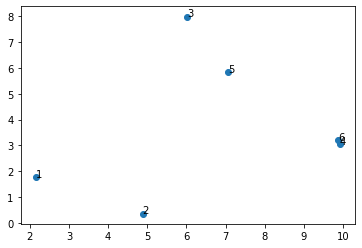

In [18]:
fig, ax = plt.subplots()
ax.scatter(x, y)
for i in range(n):
    ax.annotate(names[i], (x[i], y[i]))

And we consider the Euclidean distance between them. 

In [19]:
distances = {(names[i], names[j]): np.sqrt((x[i]-x[j])*(x[i]-x[j])+(y[i]-y[j])*(y[i]-y[j])) for i in range(n) for j in range(i+1, n) }
tsp = TSP('1', distances)

In [20]:
fullProblem = branchAndBound(tsp)

======= Iteration 1 =======
Current best tour: ['1', '5', '6', '2', '4', '3'] Length: 35.305599324239594
Treat problem ['1'] [20.60441106932112]
--> Branch
List of problems to treat:
	['1'] [20.60441106932112]
	['1', '5'] [21.865770424742813]
	['1', '6'] [23.33008606695562]
	['1', '2'] [20.60441106932112]
	['1', '4'] [23.268056614092682]
	['1', '3'] [21.652576192709326]
======= Iteration 2 =======
Current best tour: ['1', '5', '6', '2', '4', '3'] Length: 35.305599324239594
Treat problem ['1', '3'] [21.652576192709326]
--> Branch
List of problems to treat:
	['1'] [20.60441106932112]
	['1', '5'] [21.865770424742813]
	['1', '6'] [23.33008606695562]
	['1', '2'] [20.60441106932112]
	['1', '4'] [23.268056614092682]
	['1', '3'] [21.652576192709326]
	['1', '3', '5'] [21.652576192709326]
	['1', '3', '6'] [24.678402248928467]
	['1', '3', '4'] [24.764070261422656]
	['1', '3', '2'] [25.331155789439272]
======= Iteration 3 =======
Current best tour: ['1', '5', '6', '2', '4', '3'] Length: 35.3055993

In [21]:
print(f'Optimal tour: {fullProblem.optimalTour}')
print(f'Length of the optimal tour: {fullProblem.optimalValue}')

Optimal tour: ['1', '3', '5', '6', '4', '2']
Length of the optimal tour: 22.501719275387693


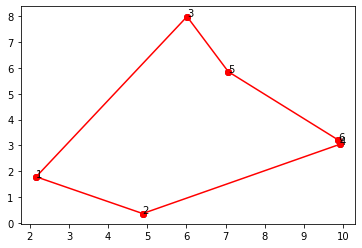

In [22]:
%matplotlib inline
fig, ax = plt.subplots()
ax.scatter(x, y)
for i in range(n):
    ax.annotate(names[i], (x[i], y[i]))
for i in range(len(fullProblem.optimalTour)-1):
    j1 = names.index(fullProblem.optimalTour[i])
    j2 = names.index(fullProblem.optimalTour[i+1])
    ax.plot([x[j1],x[j2]], [y[j1],y[j2]], 'ro-')
j1 = names.index(fullProblem.optimalTour[-1])
j2 = names.index(fullProblem.optimalTour[0])
p = ax.plot([x[j1],x[j2]], [y[j1],y[j2]], 'ro-')